In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from scipy.io import loadmat
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

Loading US Accidents dataset...
US Accidents dataset loaded.
    ID   Source  Severity           Start_Time             End_Time  \
0  A-1  Source2         3  2016-02-08 05:46:00  2016-02-08 11:00:00   
1  A-2  Source2         2  2016-02-08 06:07:59  2016-02-08 06:37:59   
2  A-3  Source2         2  2016-02-08 06:49:27  2016-02-08 07:19:27   
3  A-4  Source2         3  2016-02-08 07:23:34  2016-02-08 07:53:34   
4  A-5  Source2         2  2016-02-08 07:39:07  2016-02-08 08:09:07   

   Start_Lat  Start_Lng  End_Lat  End_Lng  Distance(mi)  ... Roundabout  \
0  39.865147 -84.058723      NaN      NaN          0.01  ...      False   
1  39.928059 -82.831184      NaN      NaN          0.01  ...      False   
2  39.063148 -84.032608      NaN      NaN          0.01  ...      False   
3  39.747753 -84.205582      NaN      NaN          0.01  ...      False   
4  39.627781 -84.188354      NaN      NaN          0.01  ...      False   

  Station   Stop Traffic_Calming Traffic_Signal Turning_Loop 

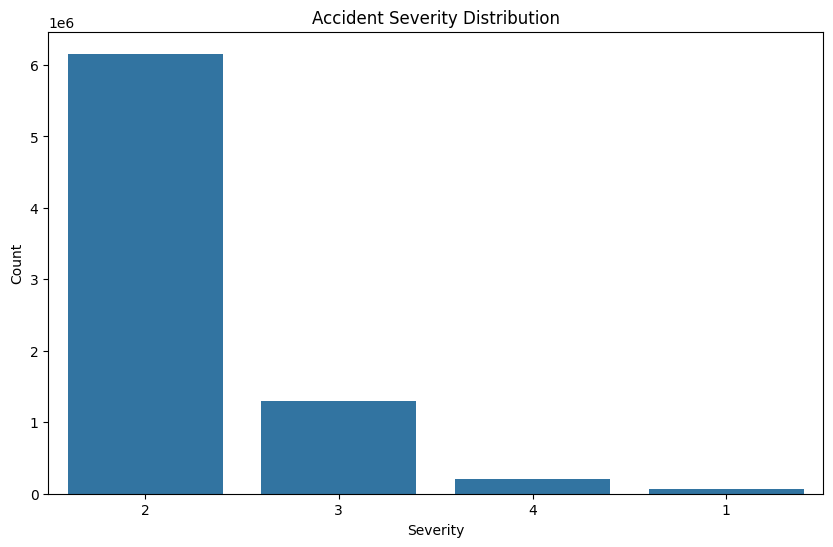

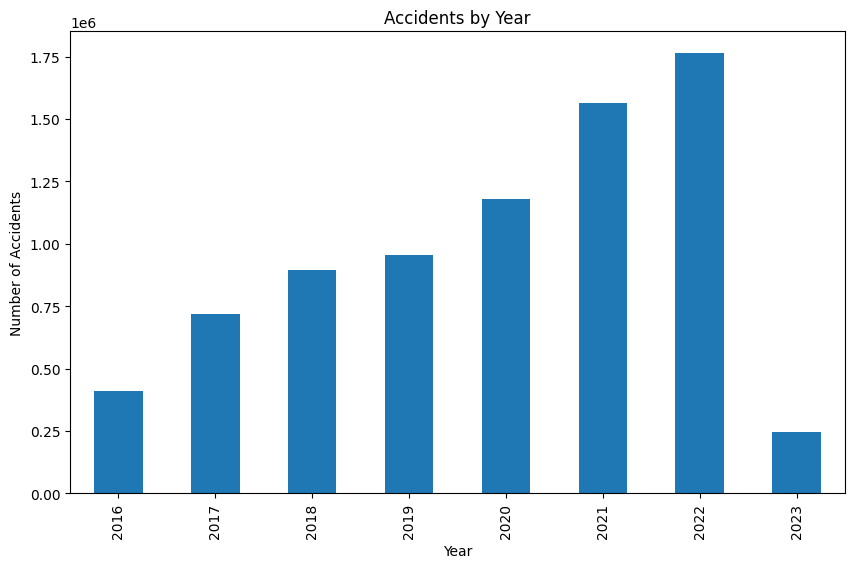

In [12]:
print("Loading US Accidents dataset...")
us_accidents = pd.read_csv('/data/US_Accidents_March23.csv')
print("US Accidents dataset loaded.")
print(us_accidents.head())

print("Dataset Info:")
us_accidents.info()

print("Performing Exploratory Data Analysis...")
plt.figure(figsize=(10, 6))
sns.countplot(data=us_accidents, x='Severity', order=us_accidents['Severity'].value_counts().index)
plt.title('Accident Severity Distribution')
plt.xlabel('Severity')
plt.ylabel('Count')
plt.show()

us_accidents['Start_Time'] = us_accidents['Start_Time'].str.split('.').str[0]
us_accidents['Start_Time'] = pd.to_datetime(us_accidents['Start_Time'].str.split('.').str[0], errors='coerce')
us_accidents['Year'] = us_accidents['Start_Time'].dt.year
plt.figure(figsize=(10, 6))
us_accidents['Year'].value_counts().sort_index().plot(kind='bar')
plt.title('Accidents by Year')
plt.xlabel('Year')
plt.ylabel('Number of Accidents')
plt.show()


In [13]:
print("Preprocessing the dataset...")
us_accidents = us_accidents.dropna(subset=['Severity', 'Start_Lat', 'Start_Lng', 'Distance(mi)'])
X = us_accidents[['Start_Lat', 'Start_Lng', 'Distance(mi)']].values
y = us_accidents['Severity'].values

X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y - 1, dtype=torch.long)  # Shift labels from 1-4 to 0-3

train_size = int(0.8 * len(X_tensor))
test_size = len(X_tensor) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(list(zip(X_tensor, y_tensor)), [train_size, test_size])
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


Preprocessing the dataset...


In [17]:
class AccidentSeverityModel(nn.Module):
    def __init__(self):
        super(AccidentSeverityModel, self).__init__()
        self.fc1 = nn.Linear(4, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 4)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

model = AccidentSeverityModel()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

print("Training the model...")
num_epochs = 2
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for batch in train_loader:
        inputs, targets = batch
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {total_loss/len(train_loader):.4f}")

print("Evaluating the model...")
model.eval()
all_preds = []
all_targets = []
with torch.no_grad():
    for batch in test_loader:
        inputs, targets = batch
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.numpy())
        all_targets.extend(targets.numpy())

print("Accuracy:", accuracy_score(all_targets, all_preds))
print("Classification Report:")
print(classification_report(all_targets, all_preds))


Training the model...
Epoch 1/2, Loss: 0.5509
Epoch 2/2, Loss: 0.5414
Evaluating the model...
Accuracy: 0.7967534009325351
Classification Report:


/Users/daehwanyoo/.pyenv/versions/3.10.13/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              precision    recall  f1-score   support

           0       0.00      0.00      0.00     13292
           1       0.80      1.00      0.89   1231296
           2       0.57      0.00      0.01    260414
           3       0.21      0.00      0.00     40677

    accuracy                           0.80   1545679
   macro avg       0.39      0.25      0.22   1545679
weighted avg       0.74      0.80      0.71   1545679



/Users/daehwanyoo/.pyenv/versions/3.10.13/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/daehwanyoo/.pyenv/versions/3.10.13/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [18]:
print("Loading Traffic Flow dataset...")
traffic_flow_data = loadmat('/data/traffic_dataset.mat')
print("Traffic Flow dataset loaded.")

print("Integrating traffic flow data...")
traffic_X_te = traffic_flow_data['tra_X_te'][0]
traffic_features = np.mean([x.mean(axis=1) for x in traffic_X_te], axis=0)
us_accidents['Traffic_Feature'] = np.random.choice(traffic_features.flatten(), size=us_accidents.shape[0], replace=True)
X = us_accidents[['Start_Lat', 'Start_Lng', 'Distance(mi)', 'Traffic_Feature']].values
y = us_accidents['Severity'].values -1

X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.long)

train_size = int(0.8 * len(X_tensor))
test_size = len(X_tensor) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(list(zip(X_tensor, y_tensor)), [train_size, test_size])
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

model = AccidentSeverityModel()
optimizer = optim.Adam(model.parameters(), lr=0.001)

print("Retraining the model with integrated data...")
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for batch in train_loader:
        inputs, targets = batch
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {total_loss/len(train_loader):.4f}")

print("Evaluating the integrated model...")
model.eval()
all_preds = []
all_targets = []
with torch.no_grad():
    for batch in test_loader:
        inputs, targets = batch
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.numpy())
        all_targets.extend(targets.numpy())

print("Integrated Model Accuracy:", accuracy_score(all_targets, all_preds))
print("Classification Report:")
print(classification_report(all_targets, all_preds))

print("Analysis complete.")


Loading Traffic Flow dataset...
Traffic Flow dataset loaded.
Integrating traffic flow data...
Retraining the model with integrated data...
Epoch 1/2, Loss: 0.5564
Epoch 2/2, Loss: 0.5435
Evaluating the integrated model...
Integrated Model Accuracy: 0.7967883370350506
Classification Report:


/Users/daehwanyoo/.pyenv/versions/3.10.13/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              precision    recall  f1-score   support

           0       0.00      0.00      0.00     13358
           1       0.80      1.00      0.89   1231371
           2       0.65      0.00      0.00    259940
           3       0.00      0.00      0.00     41010

    accuracy                           0.80   1545679
   macro avg       0.36      0.25      0.22   1545679
weighted avg       0.74      0.80      0.71   1545679

Analysis complete.


/Users/daehwanyoo/.pyenv/versions/3.10.13/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/daehwanyoo/.pyenv/versions/3.10.13/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
